# Сравнительный анализ двух подходов к подсчету площади через метод Монте-Карло


### Оценка выбора N для алгоритма, отправленного в систему

![Письменная оценка](a1i_img.jpeg)

### Визуализация экспериментов

In [52]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [37]:
%ls

a1/            a2i.cpp        p1*            p2.cpp
a2*            merge_sort.py  p1.cpp


In [76]:
compile_cmd = f"g++ -std=c++11 -O2 -o a1i_experiment a1i_experiment.cpp"
result = subprocess.run(compile_cmd, shell=True, capture_output=True, text=True, cwd="a1")

In [78]:
N_min = 100
N_max = 100000
N_step = 500
N_values = list(range(N_min, N_max + 1, N_step))

In [79]:
def run_experiment(n, region_type):
    cmd = f"./a1i_experiment {n} {region_type}"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True, cwd="a1")
    
    parts = result.stdout.strip().split()
    n_val = int(float(parts[0]))
    estimated = float(parts[1])
    exact = float(parts[2])
    return n_val, estimated, exact



In [80]:
from tqdm.notebook import tqdm
narrow_results = []

for n in tqdm(N_values):
    result = run_experiment(n, "narrow")
    narrow_results.append(result)
    
narrow_results = np.array(narrow_results)


  0%|          | 0/200 [00:00<?, ?it/s]

In [81]:
wide_results = []

for n in tqdm(N_values):
    result = run_experiment(n, "wide")
    wide_results.append(result)

wide_results = np.array(wide_results)


  0%|          | 0/200 [00:00<?, ?it/s]

In [82]:

narrow_N = narrow_results[:, 0]
narrow_area = narrow_results[:, 1]
narrow_exact = narrow_results[:, 2]
narrow_re = np.abs((narrow_area - narrow_exact) / narrow_exact) * 100

wide_N = wide_results[:, 0]
wide_area = wide_results[:, 1]
wide_exact = wide_results[:, 2]
wide_re = np.abs((wide_area - wide_exact) / wide_exact) * 100

#### График сходимости площади (в двух режимах)

На графике ниже видно, что вариант алгоритма с меньшим bounding box (bb) сходится гораздо быстрее второго варианта с большим bb.  Более того, сходится он стабильнее. <br/> <br/> 
Также интересно отметить, что начиная с примерно 1000 точек и далее до практически $10^5$ точек алгоритм с большим bb склонен недооценивать истинную площадь (хотя это вряд ли общий вывод и такое поведение скорее всего связано с конкретным значением сида). <br/><br/>
Также интересно отметить динамику сходимости: первые $10^3$ итераций оба алгоритма сходятся к истинному значению достаточно быстро. Алгоритм с широким bb даже быстрее. Однако после скорость сходимости серьезно падает.

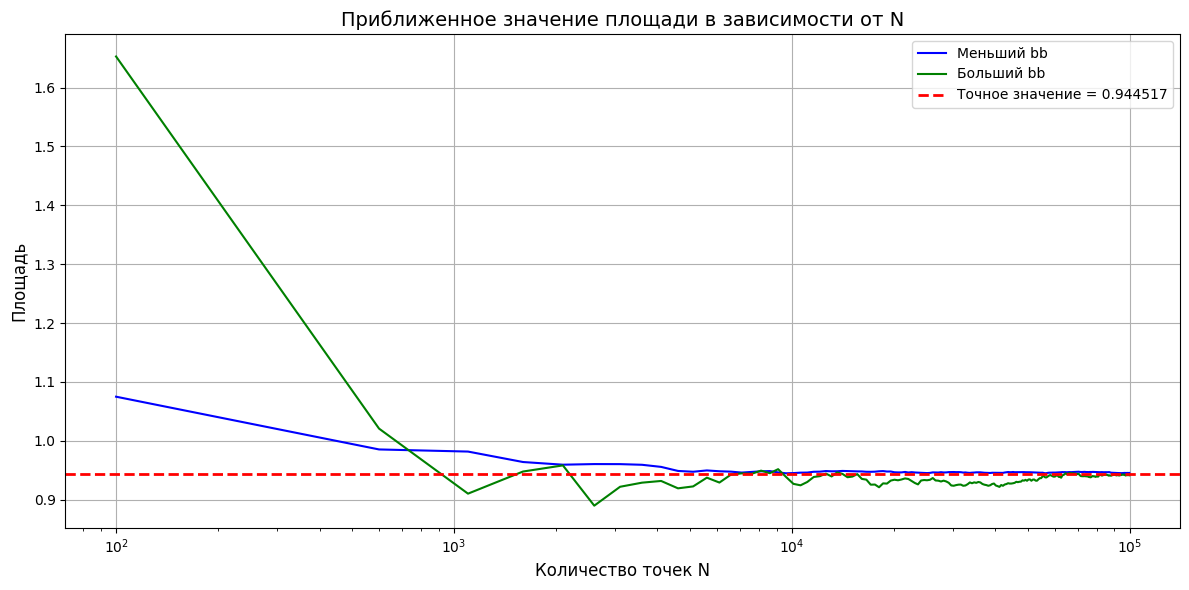

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(narrow_N, narrow_area, 'b-', linewidth=1.5, label='Меньший bb')
plt.plot(wide_N, wide_area, 'g-', linewidth=1.5, label='Больший bb')
plt.axhline(y=narrow_exact[0], color='r', linestyle='--', linewidth=2, label=f'Точное значение = {narrow_exact[0]:.6f}')
plt.xlabel('Количество точек N', fontsize=12)
plt.ylabel('Площадь', fontsize=12)
plt.title('Приближенное значение площади в зависимости от N', fontsize=14)
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.tight_layout()


#### График относительной ошибки

На графике относительной ошибки мы видим ту же самую картину: вариант с меньшей площадью bb ведет себя более стабильно и сходится очевидно быстрее и стабильнее, чем вариат с широким bb. Тут мы также видим ту самую динамику сходимости. ДО $10^3$ ошибка падает стабильно, однако уже после этой отметки мы видим, что оба алгоритма начинают колебаться возле истинного значения. Про алгоритм с большим bb можно вообще сказать, что с $10^3$ ошибка ведет себя абсолютно нестабильно и выходит на плато в районе $10^5$ <br/><br/>
Конечно значение ошибки для широкого bb в итоге оказывается выше, чем для узкого.

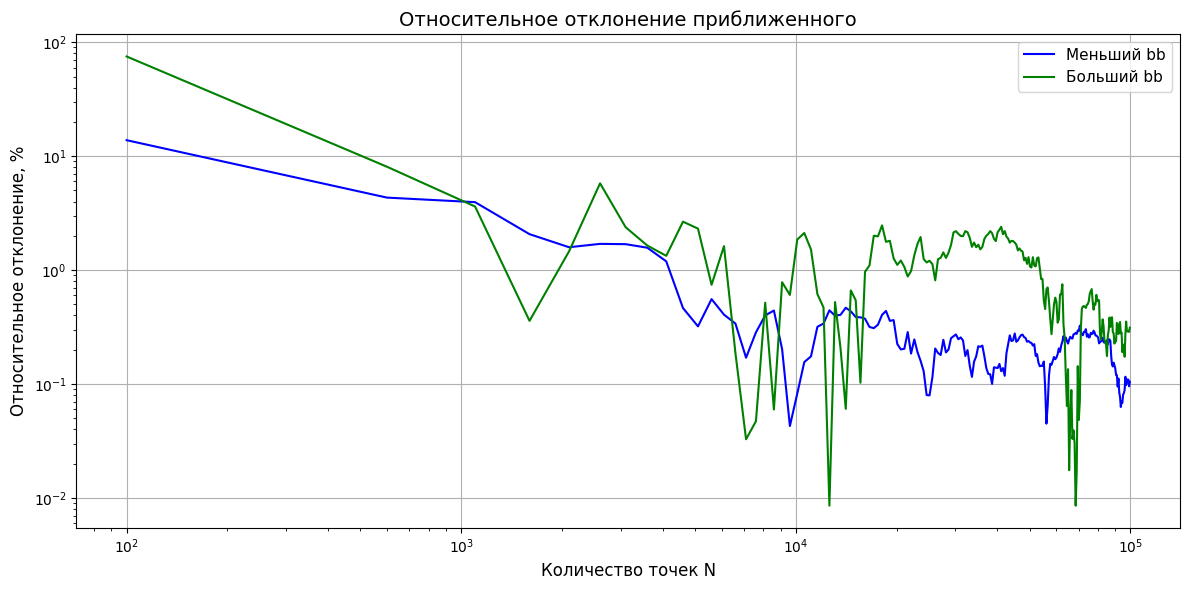

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(narrow_N, narrow_re, 'b-', linewidth=1.5, label='Меньший bb')
plt.plot(wide_N, wide_re, 'g-', linewidth=1.5, label='Больший bb')
plt.xlabel('Количество точек N', fontsize=12)
plt.ylabel('Относительное отклонение, %', fontsize=12)
plt.title('Относительное отклонение приближенного', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()


## Итог

Как и ожидалось, алгоритм с более узким bb выдает качество предсказания лучше и ведет себя стабильнее. Интуитивно объяснить это не сложно, так как при прочих равных на большем масштабе нам потребуется больше точек для корректной оценки площади в случае большего bb, тогда как в случае с узким bb мы уже достаточно точно определили область пространства, в которой находится искомая фигура, а значит сильно упростили алгоритму жизнь.